In [ ]:
import xgboost as xgb

# New Section

In [ ]:
import os
from datetime import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
control_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/control/control_1.csv')
condition_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/condition/condition_1.csv')
print(f'control_1.shape: {control_1.shape}')
print(f'condition_1.shape: {condition_1.shape}')

control_1.shape: (51611, 3)
condition_1.shape: (23244, 3)


In [ ]:
control_1.head()

timestamp        date  activity
0  2003-03-18 15:00:00  2003-03-18        60
1  2003-03-18 15:01:00  2003-03-18         0
2  2003-03-18 15:02:00  2003-03-18       264
3  2003-03-18 15:03:00  2003-03-18       662
4  2003-03-18 15:04:00  2003-03-18       293

In [ ]:
condition_1.head()

timestamp        date  activity
0  2003-05-07 12:00:00  2003-05-07         0
1  2003-05-07 12:01:00  2003-05-07       143
2  2003-05-07 12:02:00  2003-05-07         0
3  2003-05-07 12:03:00  2003-05-07        20
4  2003-05-07 12:04:00  2003-05-07       166

In [ ]:
control_1.describe()

activity
count  51611.000000
mean      98.545078
std      289.655317
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max     6117.000000

In [ ]:
condition_1.describe()

activity
count  23244.000000
mean     146.948030
std      294.592424
min        0.000000
25%        0.000000
50%        9.000000
75%      172.000000
max     3526.000000

<Axes: xlabel='activity', ylabel='Count'>

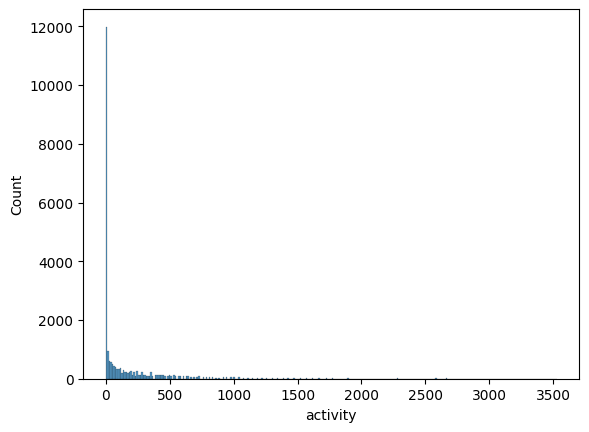

In [ ]:
sns.histplot(x='activity', data=condition_1)

In [ ]:
condition_1['activity'].skew()

3.8823677090908344

In [ ]:
condition_1['log_activity'] = np.log(condition_1['activity'] + 1) # add + 1 because log(0) is infinity
condition_1['log_activity'].skew()

0.2771381485812395

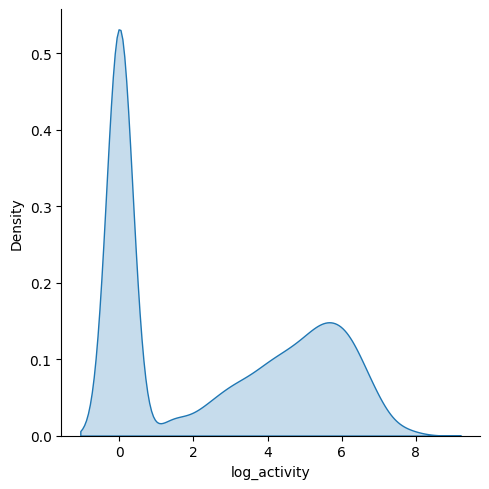

In [ ]:
sns.displot(x='log_activity', data=condition_1, kind='kde', fill=True)

In [ ]:
condition_1['sqrt_activity'] = np.sqrt(condition_1['activity'])
condition_1['sqrt_activity'].skew()

1.370447546298057

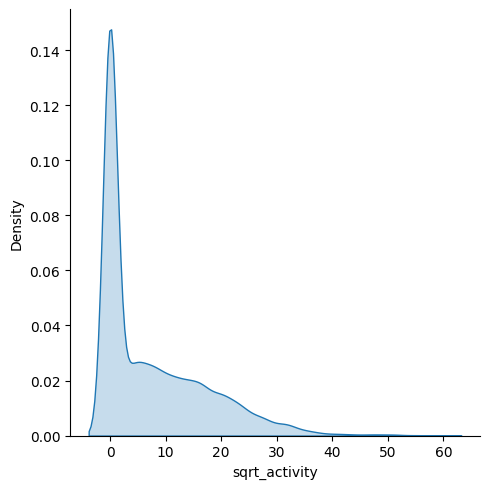

In [ ]:
sns.displot(x='sqrt_activity', data=condition_1, kind='kde', fill=True)

In [ ]:
condition_1.describe()

activity  log_activity  sqrt_activity
count  23244.000000  23244.000000   23244.000000
mean     146.948030      2.562035       7.416512
std      294.592424      2.626393       9.588917
min        0.000000      0.000000       0.000000
25%        0.000000      0.000000       0.000000
50%        9.000000      2.302585       3.000000
75%      172.000000      5.153292      13.114877
max     3526.000000      8.168203      59.380131

In [ ]:
control_1['activity'].skew()

5.039169993104665

In [ ]:
control_1.describe()

activity
count  51611.000000
mean      98.545078
std      289.655317
min        0.000000
25%        0.000000
50%        0.000000
75%        3.000000
max     6117.000000

In [ ]:
control_1['log_activity'] = np.log(control_1['activity'] + 1)
control_1['log_activity'].skew()

1.2517081703386566

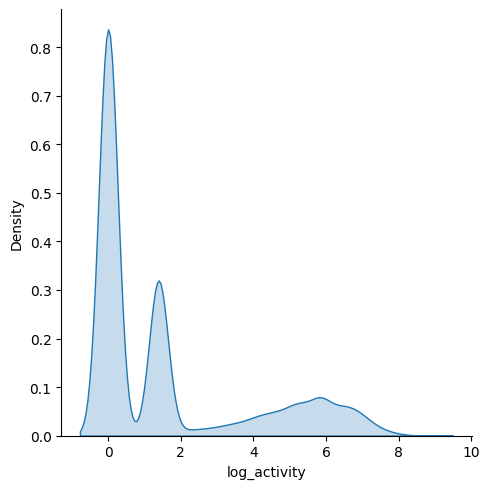

In [ ]:
sns.displot(x='log_activity', data=control_1, kind='kde', fill=True)

In [ ]:
condition_1.head()

timestamp        date  activity  log_activity  sqrt_activity
0  2003-05-07 12:00:00  2003-05-07         0      0.000000       0.000000
1  2003-05-07 12:01:00  2003-05-07       143      4.969813      11.958261
2  2003-05-07 12:02:00  2003-05-07         0      0.000000       0.000000
3  2003-05-07 12:03:00  2003-05-07        20      3.044522       4.472136
4  2003-05-07 12:04:00  2003-05-07       166      5.117994      12.884099

In [ ]:
df = condition_1.groupby('date')['log_activity'].mean().reset_index()
df.head()

date  log_activity
0  2003-05-07      3.752204
1  2003-05-08      2.931977
2  2003-05-09      2.593095
3  2003-05-10      2.910573
4  2003-05-11      2.561446

In [ ]:
def combine_data(path):
    dirs = os.listdir(path)
    combine_df = []
    
    for filepath in dirs:
        source = filepath.split('.')[0]
        if filepath.endswith('.csv'):
            X = pd.read_csv(path + filepath, parse_dates=['timestamp'], index_col='timestamp')
            X['source'] = source
            combine_df.append(X)
        
    return combine_df


In [ ]:
combine_df = combine_data('/content/drive/MyDrive/Colab Notebooks/dataset/condition/')

In [ ]:
conditions = []
for condition in combine_df:
    condition_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    condition_df['mean_activity'] = condition.activity.resample('H').mean()
    condition_df['std_activity'] = condition.activity.resample('H').std()
    condition_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in condition.activity.resample('H')]
    condition_df['source'] = condition.source
    conditions.append(condition_df)

In [ ]:
combine_df = combine_data('/content/drive/MyDrive/Colab Notebooks/dataset/control/')

In [ ]:
controls = []
for control in combine_df:
    control_df = pd.DataFrame(columns=['mean_activity', 'std_activity', 'zero_activity_proportion', 'source'])
    control_df['mean_activity'] = control.activity.resample('H').mean()
    control_df['std_activity'] = control.activity.resample('H').std()
    control_df['zero_activity_proportion'] = [data[1].tolist().count(0) for data in control.activity.resample('H')]
    control_df['source'] = control.source
    controls.append(control_df)

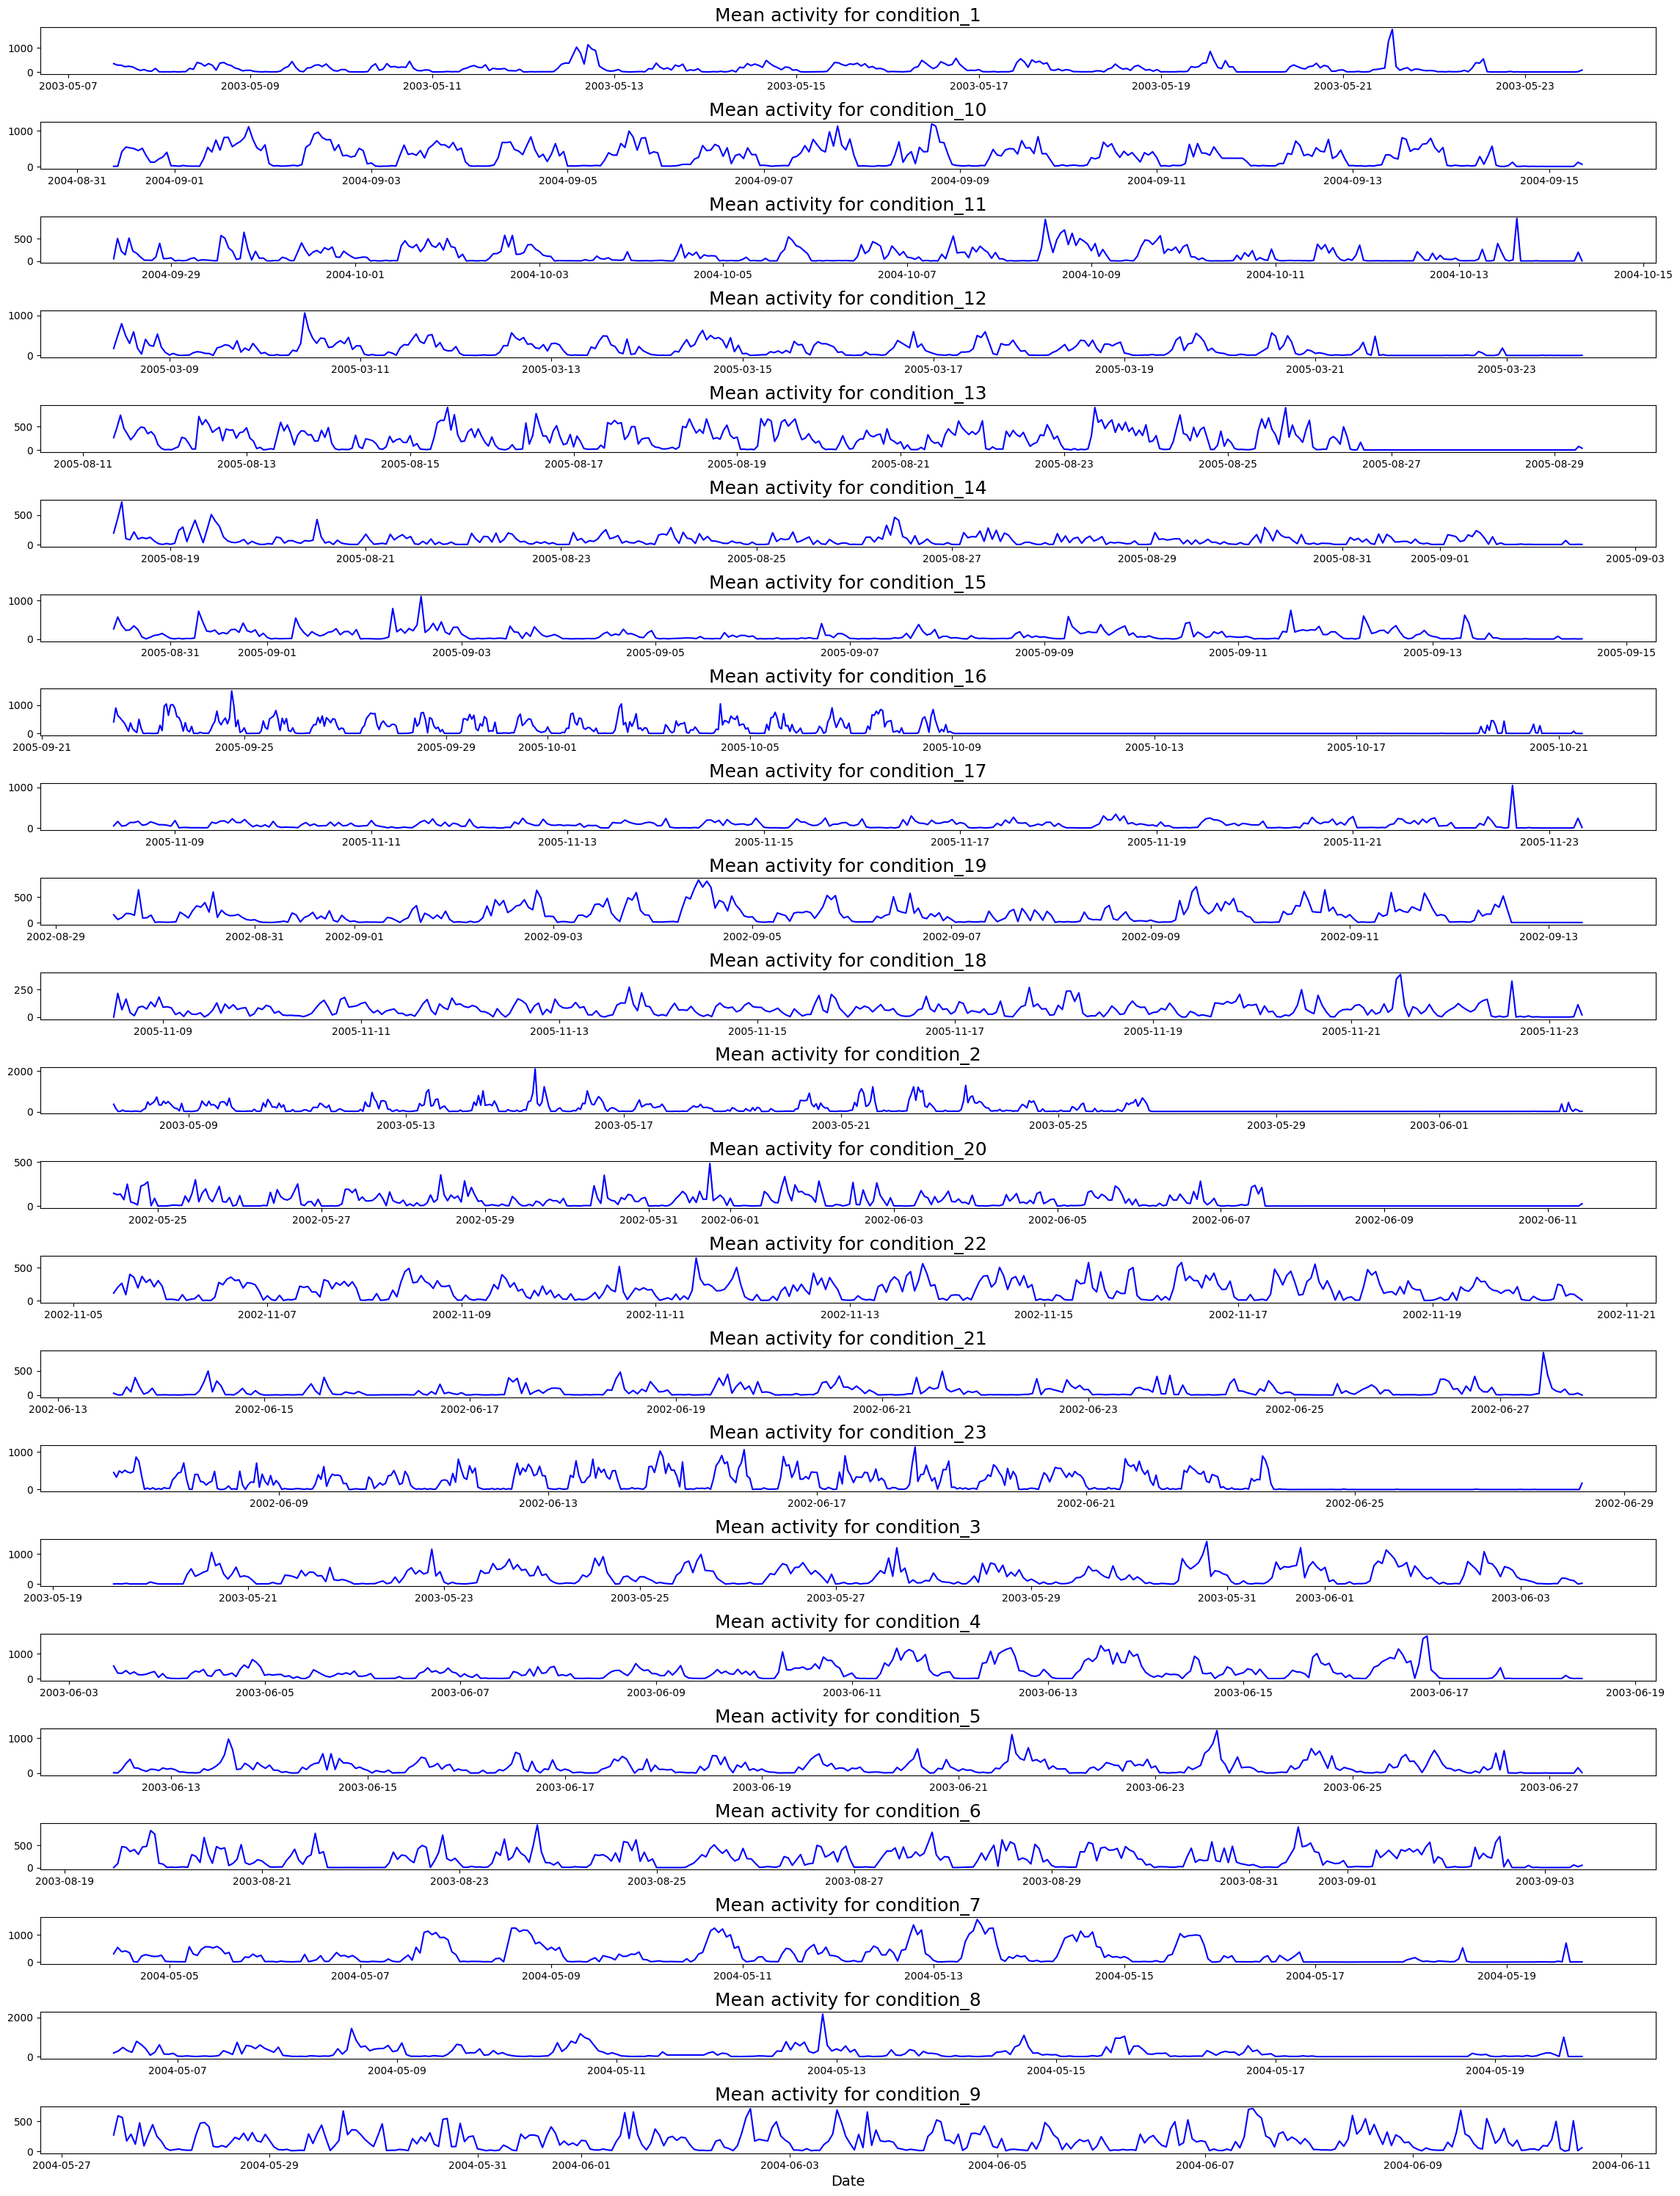

In [ ]:
fig, axes = plt.subplots(23, 1, figsize=(23, 30))
cnt = 0
for i in range(23):
    condition = conditions[cnt]
    axes[i].plot(condition.index, condition.mean_activity, color='b')
    axes[i].set_title(f'Mean activity for {condition.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of condition group.jpg', dpi=100)
plt.show()

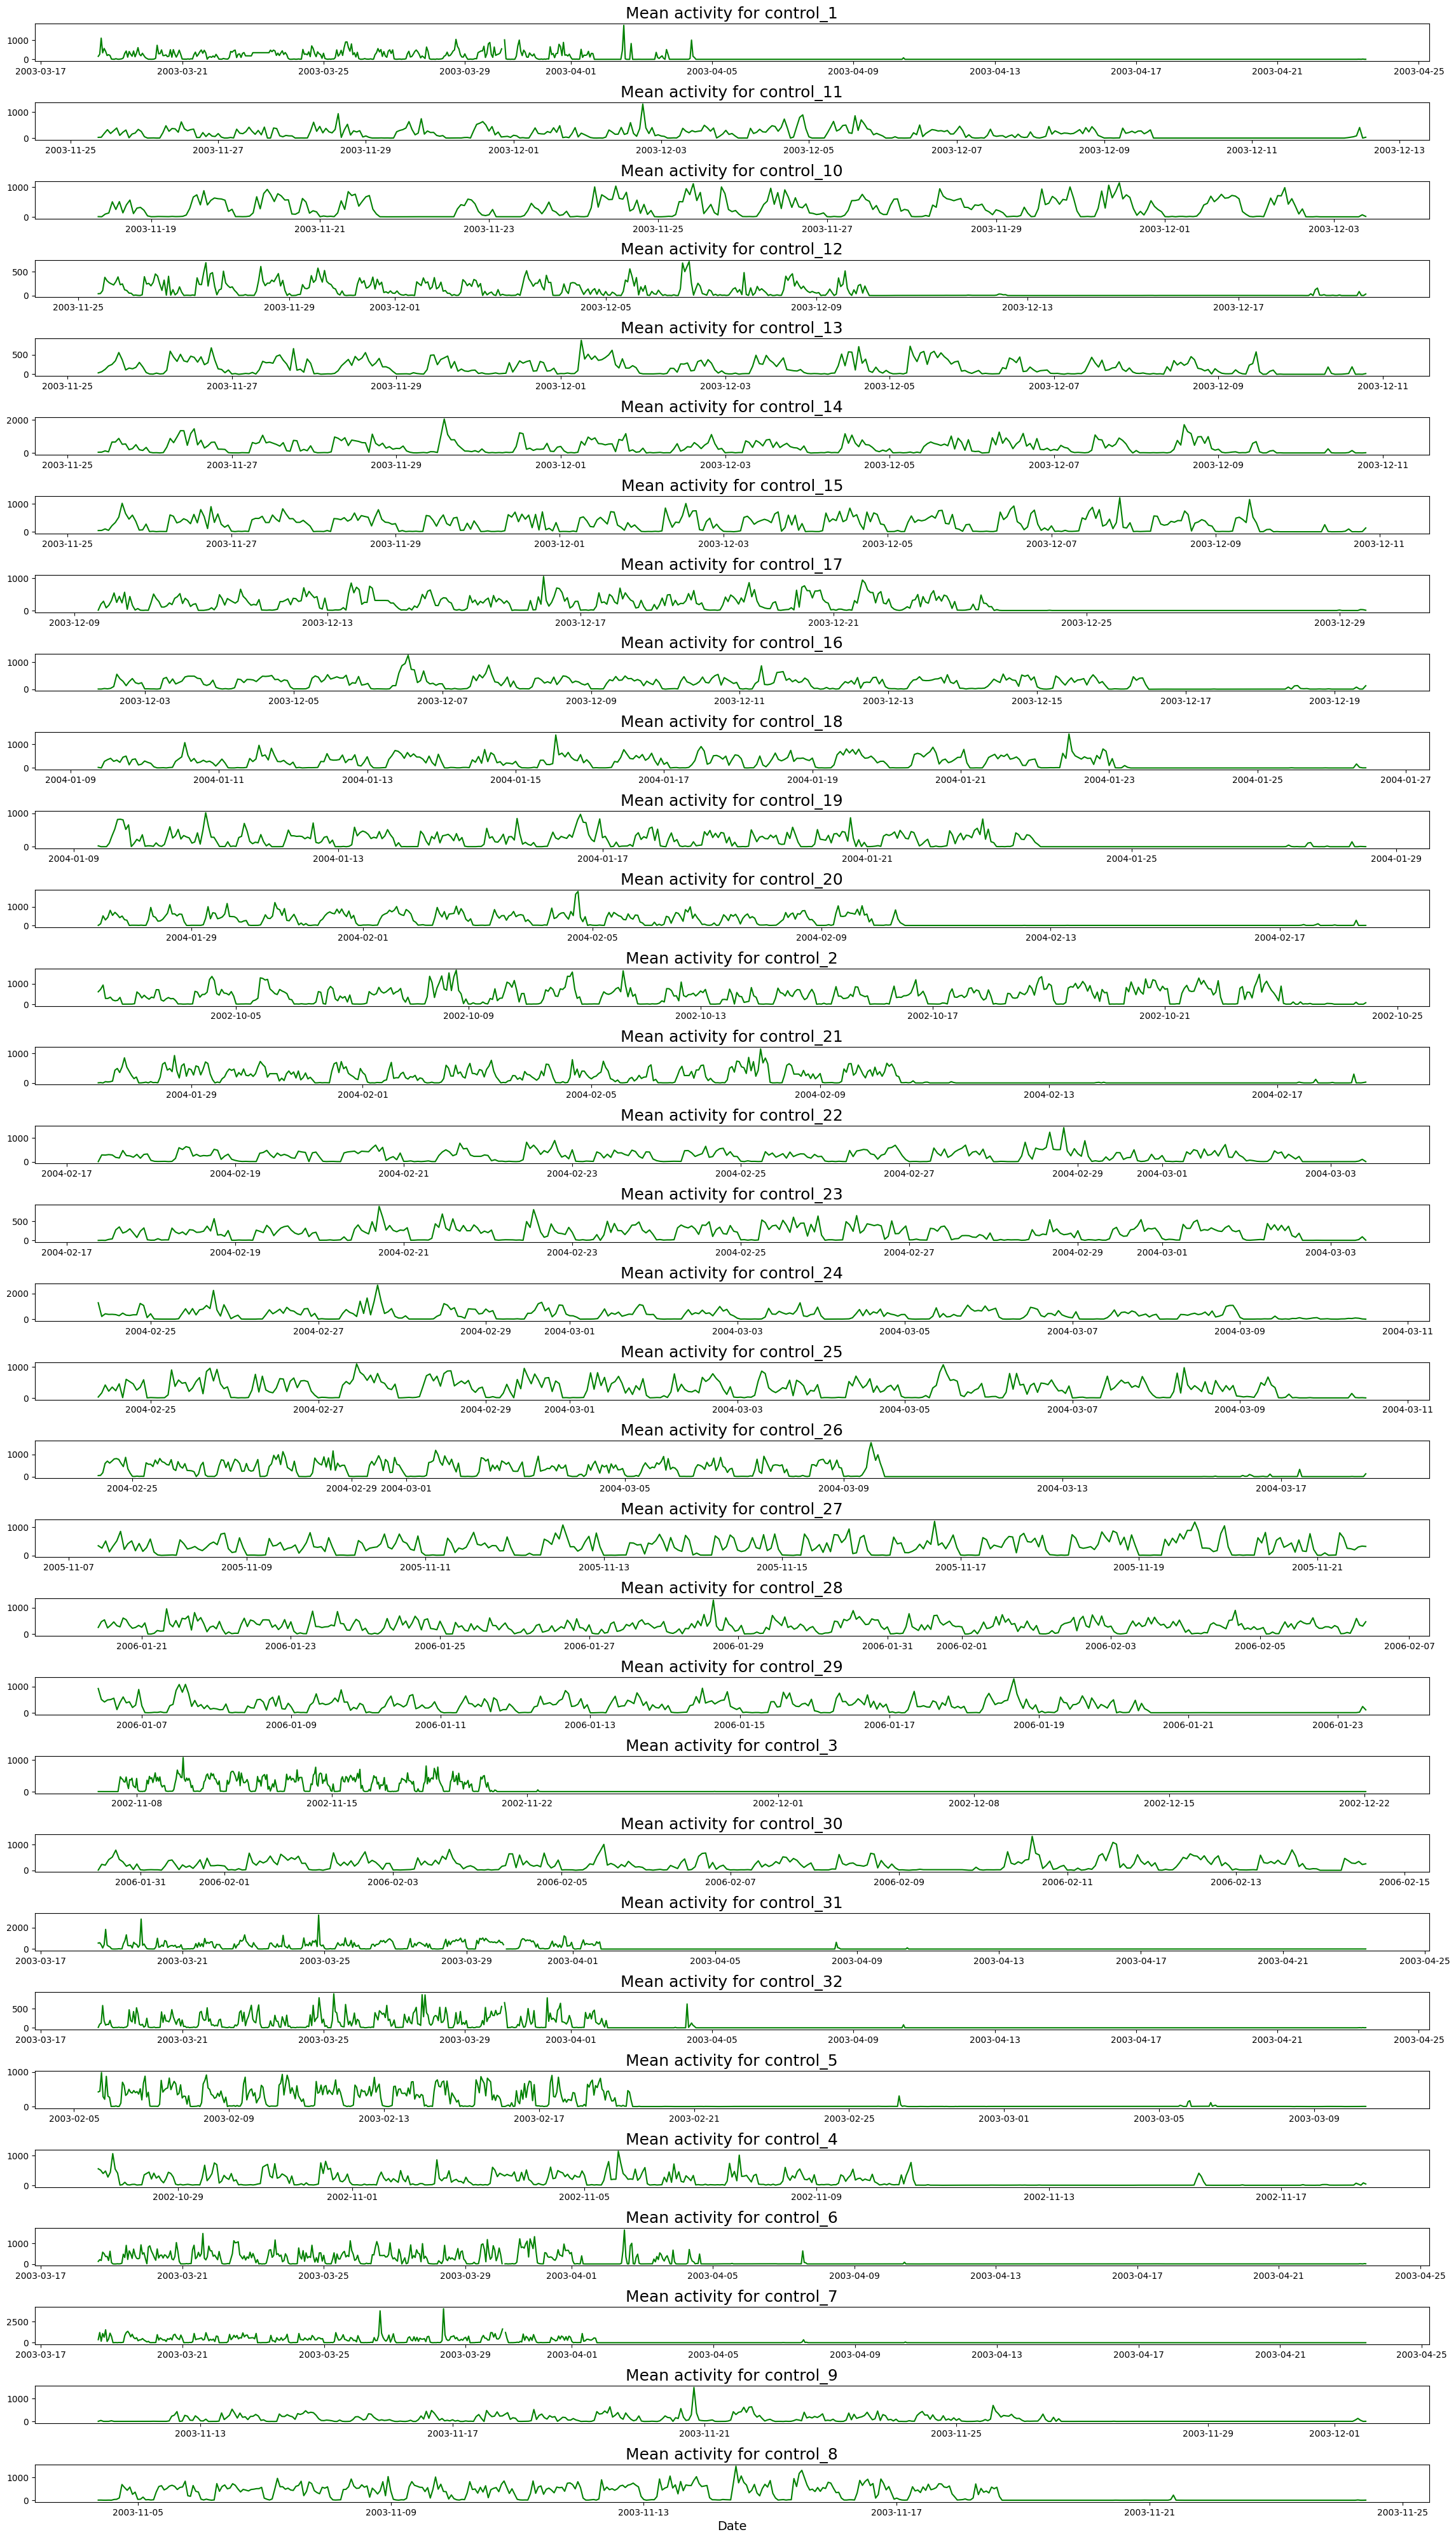

In [ ]:
fig, axes = plt.subplots(32, 1, figsize=(23, 40))
cnt = 0
for i in range(32):
    control = controls[cnt]
    axes[i].plot(control.index, control.mean_activity, color='g')
    axes[i].set_title(f'Mean activity for {control.source[1]}', fontsize=18)
    cnt += 1
    
plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
fig.savefig('Mean activity of control group.jpg', dpi=100)
plt.show()

In [ ]:
def to_clock(x):
    d = datetime.strptime(f'{x}:00', '%H:%M')
    return d.strftime('%I:%M %p')

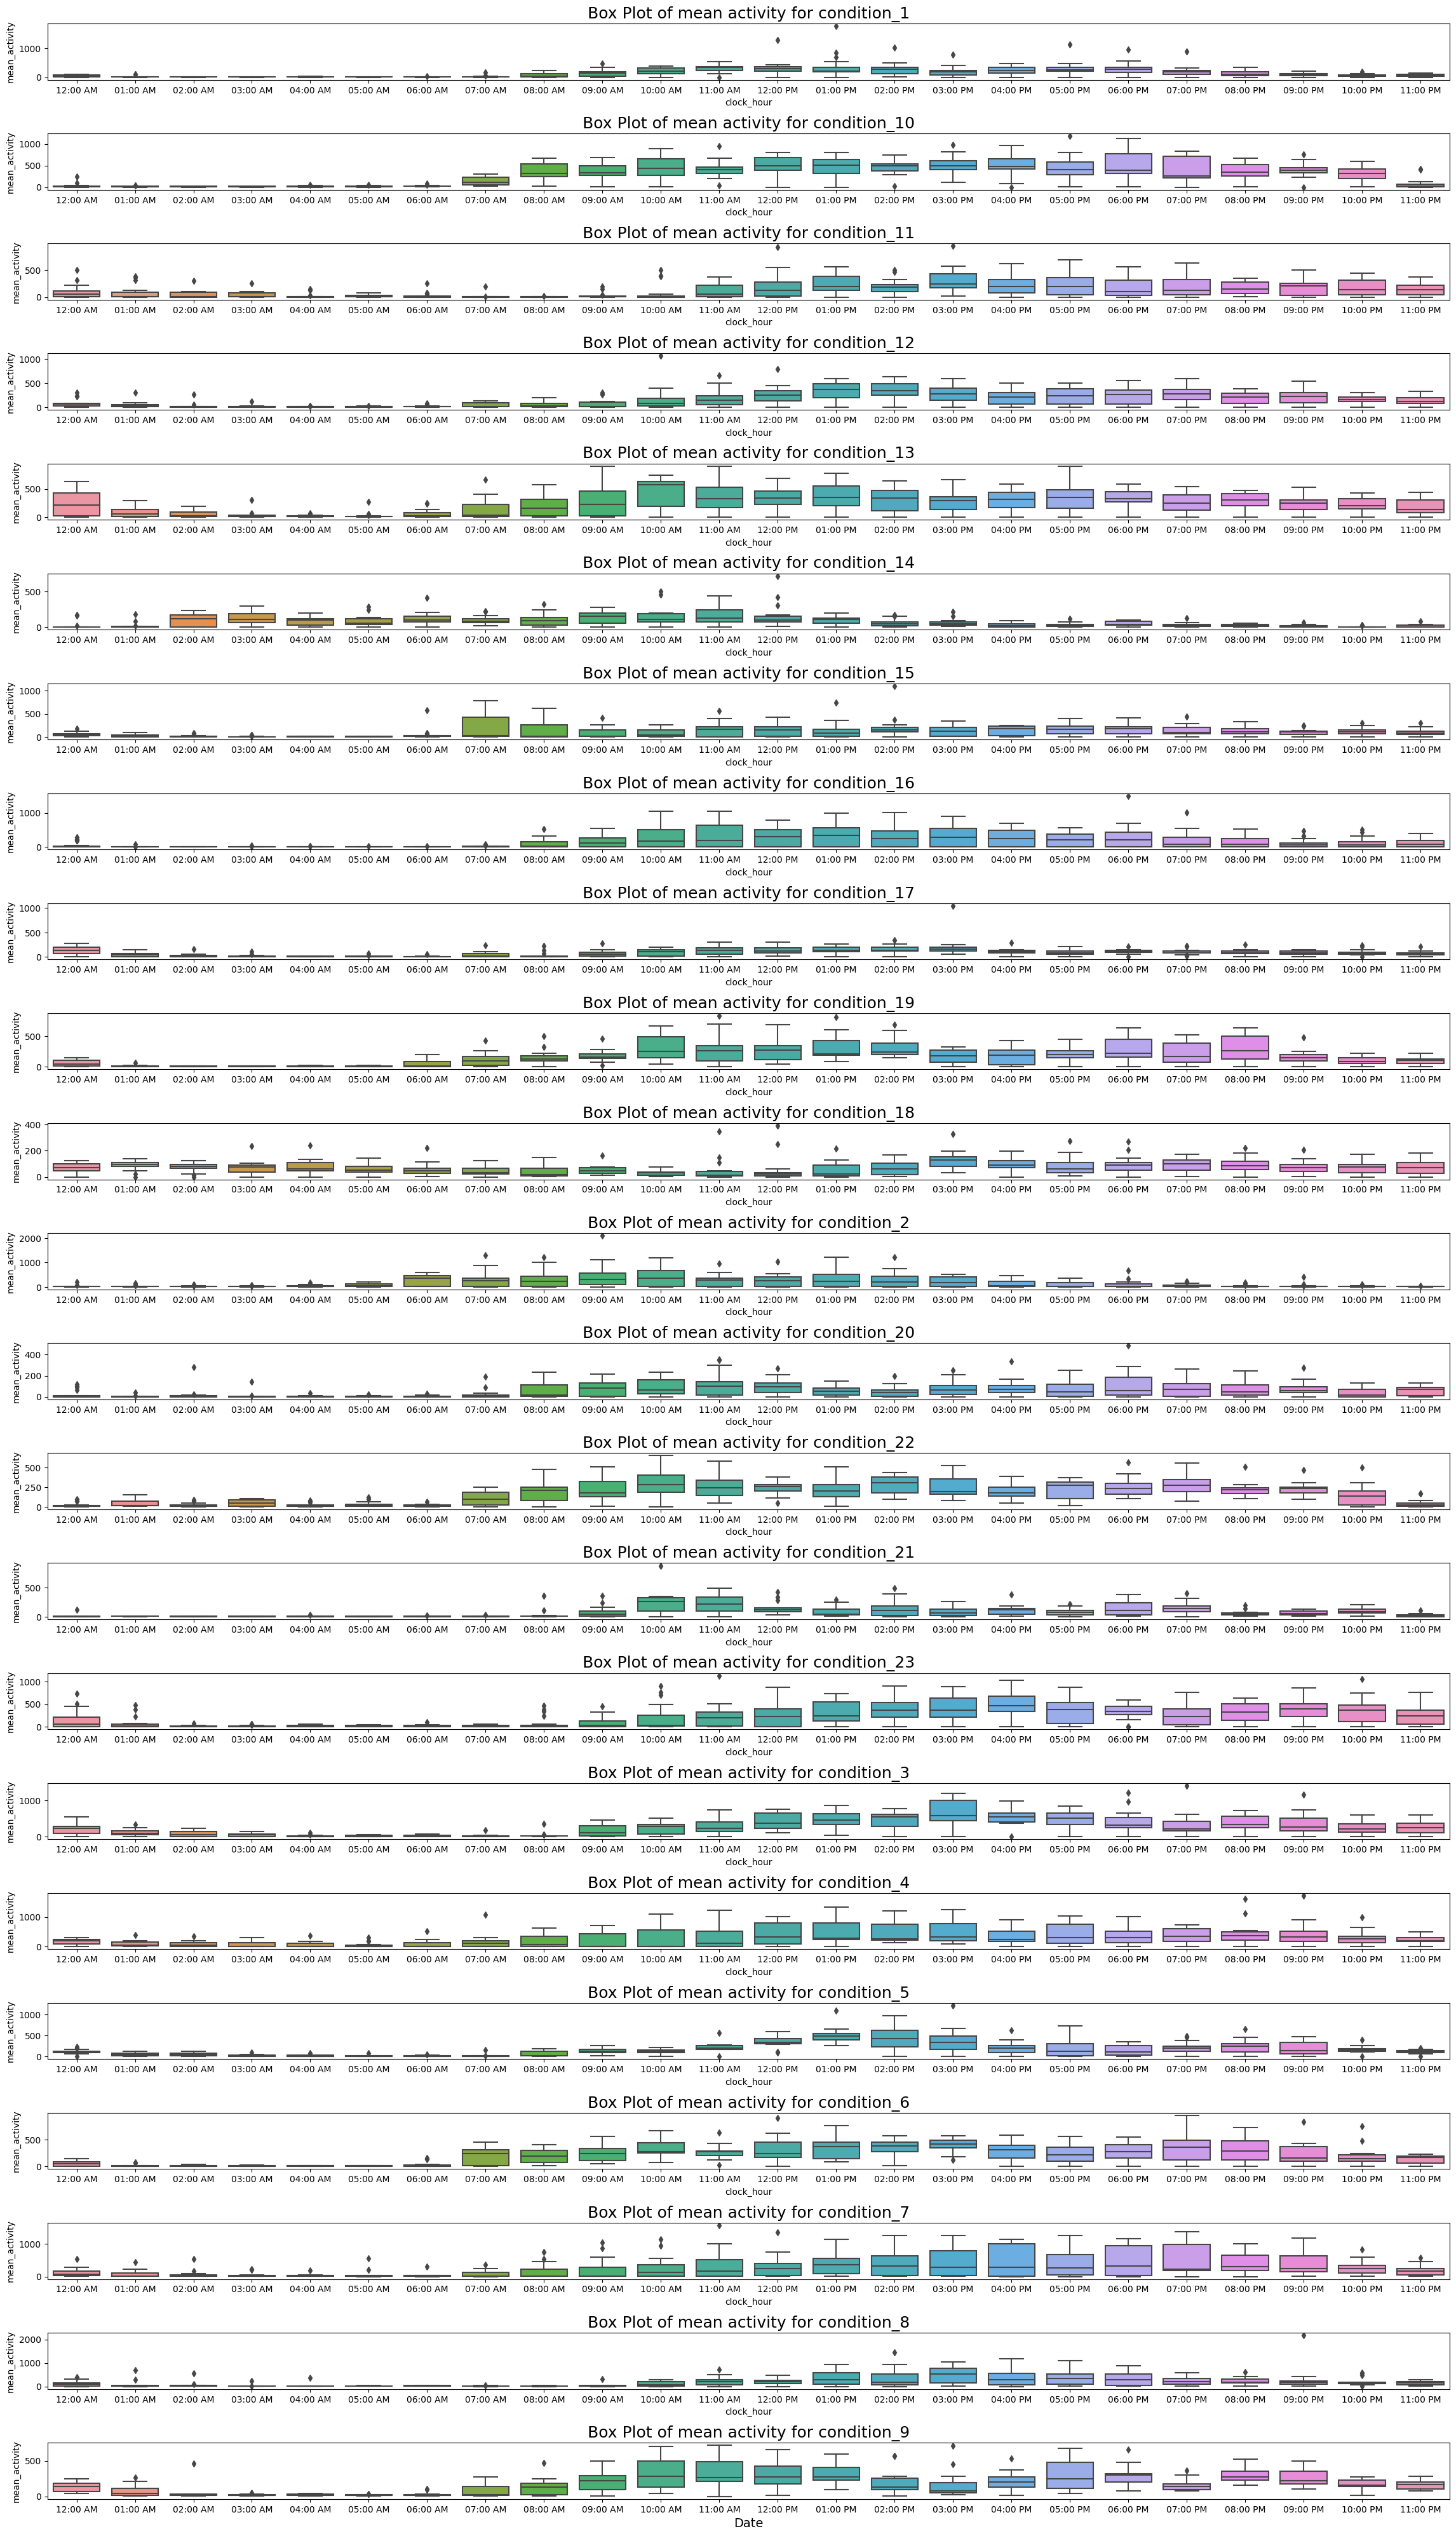

In [ ]:
fig, axes = plt.subplots(23, 1, figsize=(23, 40))

cnt = 0
for i in range(23):
    df = conditions[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

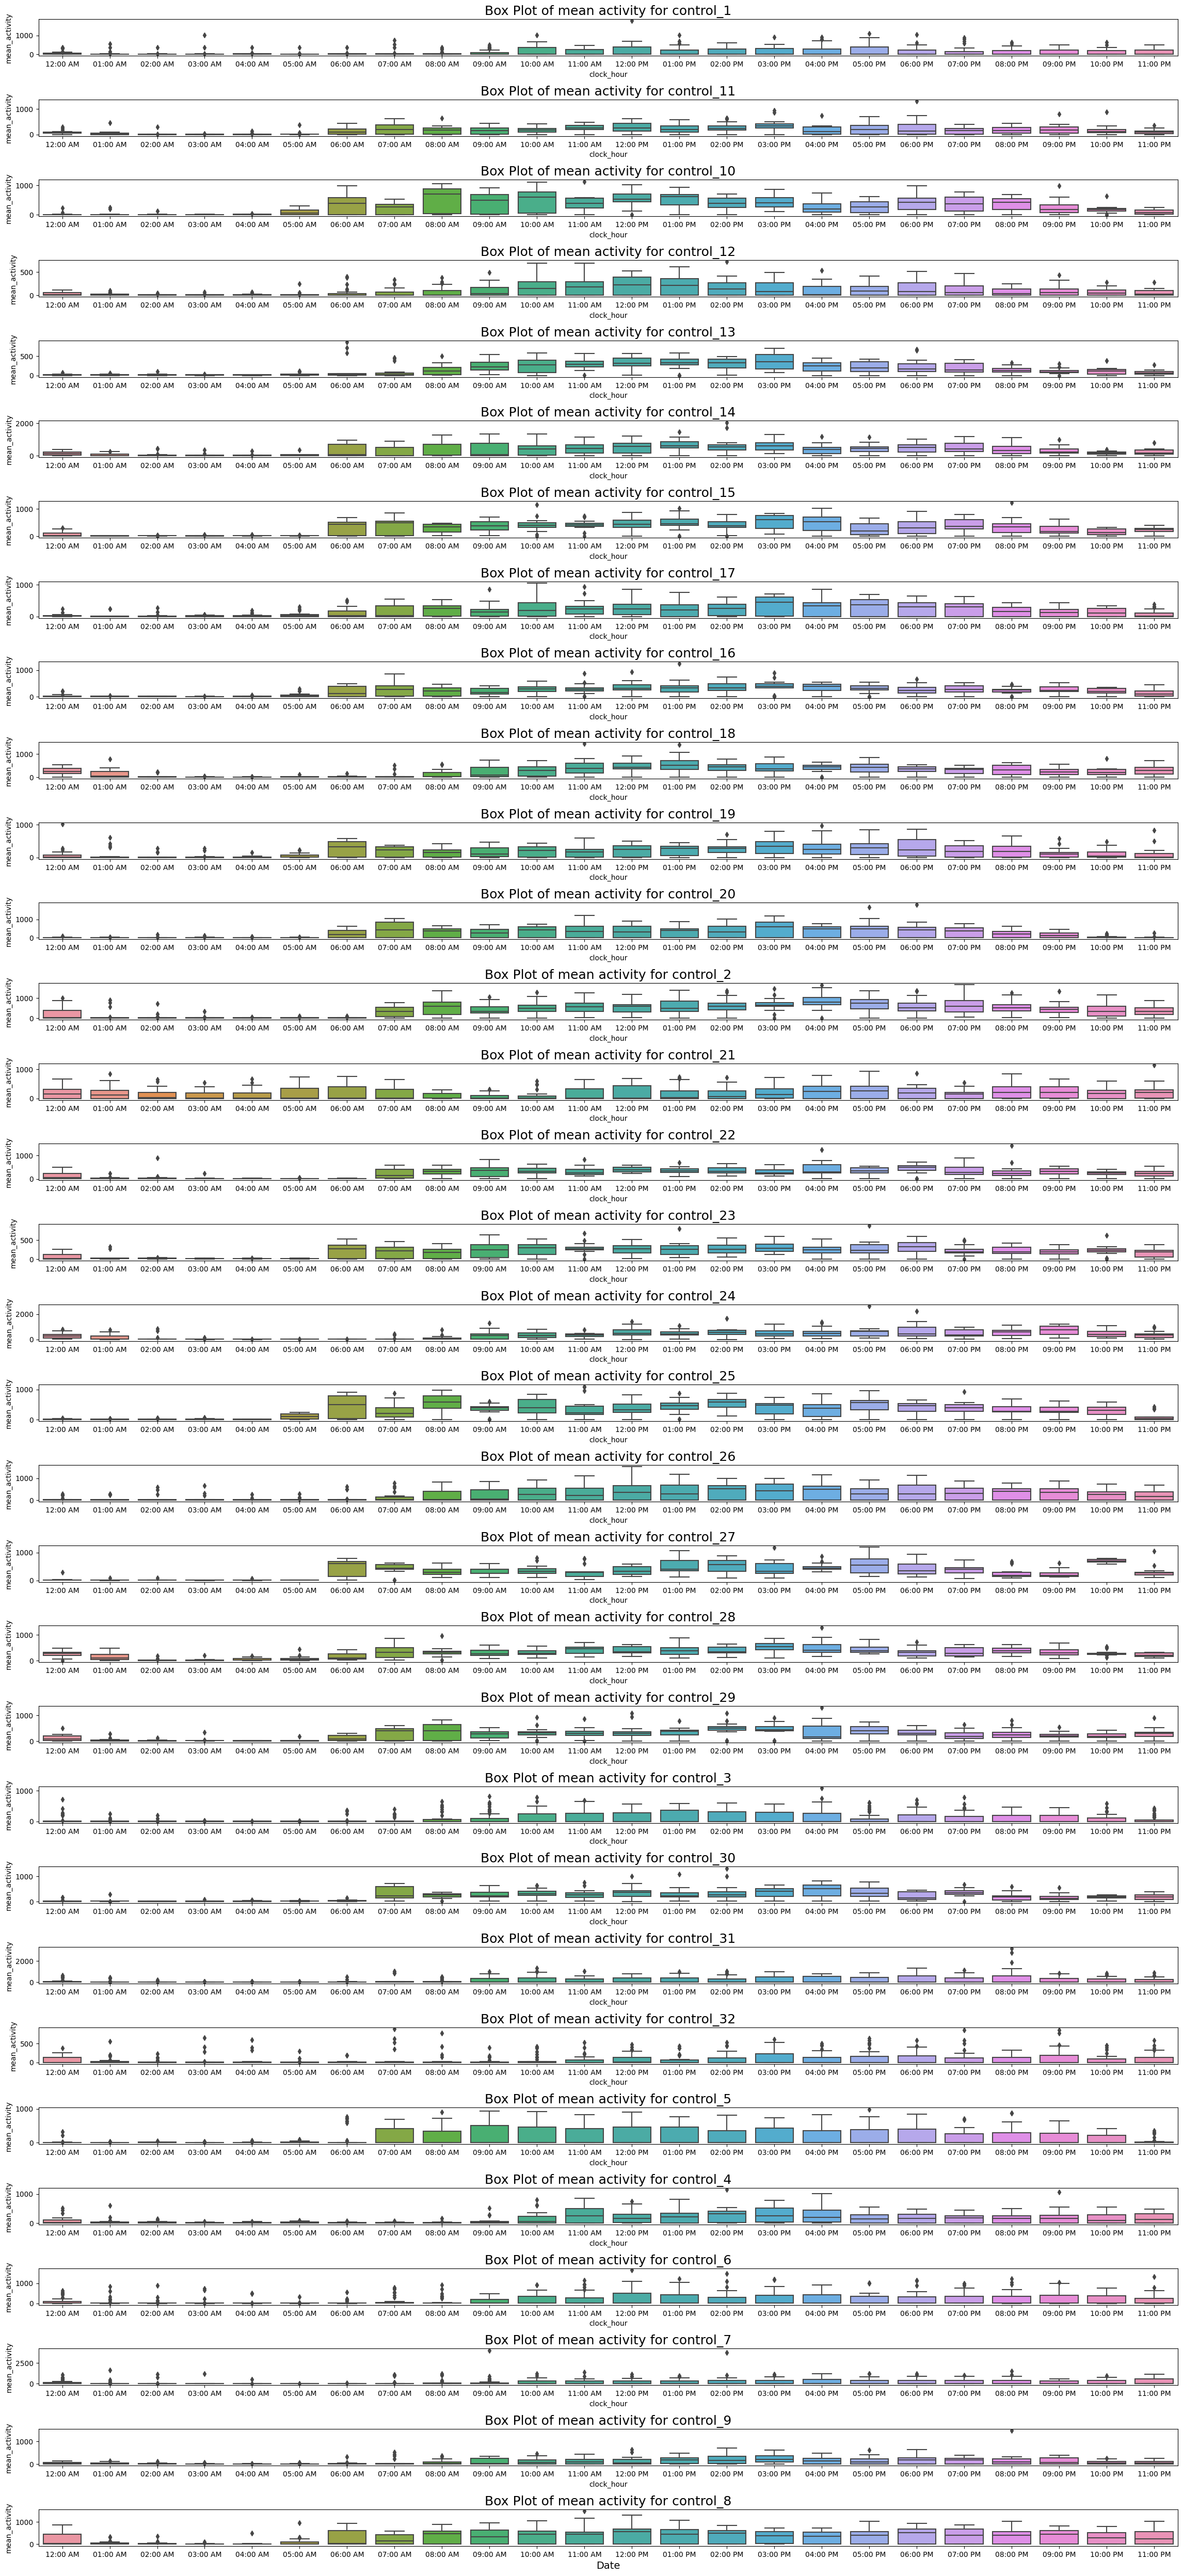

In [ ]:
# Draw Plot
fig, axes = plt.subplots(32, 1, figsize=(23, 50))

cnt = 0
for i in range(32):
    df = controls[i].reset_index()

    # Prepare data
    df['hour'] = [d.hour for d in df.timestamp]
    df = df.sort_values('hour')
    df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
    sns.boxplot(x='clock_hour', y='mean_activity', data=df, ax=axes[i])
    axes[i].set_title(f'Box Plot of mean activity for {df.source[1]}', fontsize=18)
    cnt += 1

plt.xlabel('Date', fontsize=14)
fig.tight_layout(pad=1.0)
plt.show()

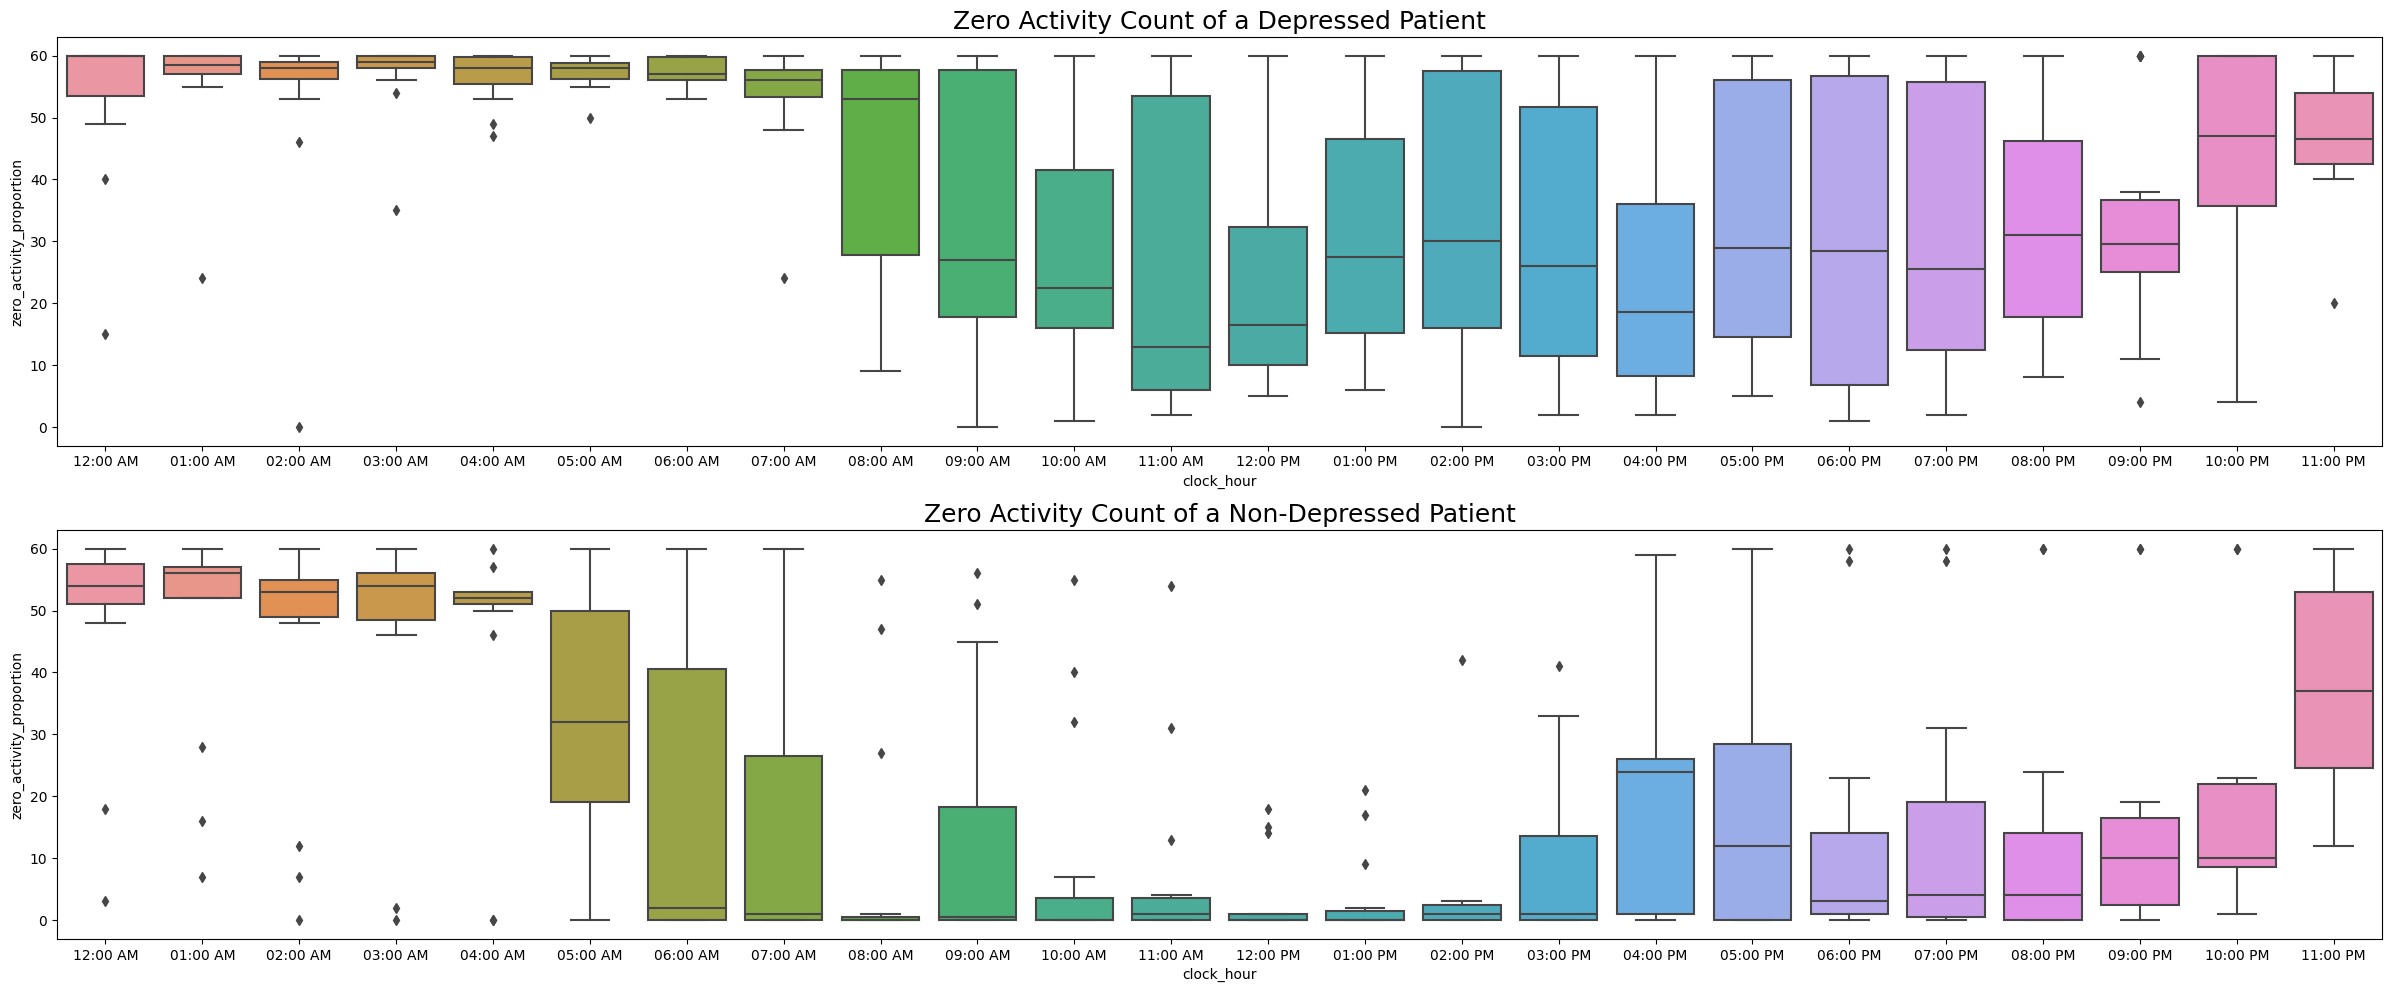

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(24, 10))
df = conditions[12].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[0])
axes[0].set_title('Zero Activity Count of a Depressed Patient', fontsize=18)

df = controls[2].reset_index()
df['hour'] = [d.hour for d in df.timestamp]
df = df.sort_values('hour')
df['clock_hour'] = df['hour'].apply(lambda x: to_clock(x))
sns.boxplot(x='clock_hour', y='zero_activity_proportion', data=df, ax=axes[1])
axes[1].set_title('Zero Activity Count of a Non-Depressed Patient', fontsize=18)

fig.tight_layout(pad=1.0)
plt.show()

In [ ]:
def nextday(dates):
    for date in dates:
        yield date
      
def zero_count(series):
    return list(series).count(0)

def extractfeatures(X, date):
    mask = X['date'] == date
    d = {
        'mean_log_activity': X[mask]['log_activity'].mean(),
        'std_log_activity': X[mask]['log_activity'].std(),
        'min_log_activity': X[mask]['log_activity'].min(),
        'max_log_activity': X[mask]['log_activity'].max(),
        'zero_proportion_activity': zero_count(X[mask]['log_activity'])
    }
    return d


In [ ]:
class ExtractData(BaseEstimator, TransformerMixin):
    
    def __init__(self, path):
        self.path = path
        self.X = []

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        dirs = os.listdir(self.path)
        
        for filepath in sorted(dirs, key=lambda x: x.split('_')[0]):
            condition = filepath.split('.')[0]
            if filepath.endswith('.csv'):
                X = pd.read_csv(self.path + filepath)
                X['log_activity'] = np.log(X['activity'] + 1)
                dates = X.date.unique()
                
                for date in nextday(dates):
                    d = extractfeatures(X, date)
                    d['source'] = condition
                    self.X.append(d)
                

        return pd.DataFrame(self.X)

In [ ]:
e = ExtractData(path='/content/drive/MyDrive/Colab Notebooks/dataset/condition/')
conditions = e.fit_transform(X=None, y=None)
conditions['state'] = 1

In [ ]:
conditions.tail()

mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
400           2.836361          2.604526               0.0          7.789869   
401           3.317860          2.664783               0.0          7.945201   
402           3.174113          2.653188               0.0          7.664816   
403           2.860525          2.617277               0.0          7.696213   
404           1.648750          2.476757               0.0          7.602900   

     zero_proportion_activity       source  state  
400                       578  condition_9      1  
401                       491  condition_9      1  
402                       505  condition_9      1  
403                       572  condition_9      1  
404                       596  condition_9      1

In [ ]:
e = ExtractData(path='/content/drive/MyDrive/Colab Notebooks/dataset/control/')
controls = e.fit_transform(X=None, y=None)
controls['state'] = 0

In [ ]:
full_df = controls.append(conditions, ignore_index=True)
full_df.head()

<ipython-input-38-156b248be5eb>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = controls.append(conditions, ignore_index=True)


mean_log_activity  std_log_activity  min_log_activity  max_log_activity  \
0           4.269175          2.536873               0.0          7.758761   
1           3.006935          2.636401               0.0          8.038512   
2           3.220895          2.683718               0.0          7.883069   
3           2.737783          2.699849               0.0          7.633854   
4           3.302284          2.641430               0.0          7.789869   

   zero_proportion_activity     source  state  
0                       106  control_1      0  
1                       557  control_1      0  
2                       516  control_1      0  
3                       657  control_1      0  
4                       520  control_1      0

In [ ]:
full_df.shape

(1144, 7)

In [ ]:
full_df = full_df.sample(frac=1) # reshufle the dataset

In [ ]:
X = full_df.drop(['state'], axis=1)
y = full_df.state

In [ ]:
def custom_train_test_split(train_set, test_set):
    X_train = train_set.drop('label', axis=1)
    y_train = train_set.label
    X_test = test_set.drop('label', axis=1)
    y_test = test_set.label
    
    return X_train, X_test, y_train, y_test

In [ ]:
class CustomClassifierCV(BaseEstimator, TransformerMixin):
    
    def __init__(self, base_clf):
        self.base_clf = base_clf
    
    def fit(self, X, y=None):
        X['label'] = y
        participants = X.source.unique()
        folds = []
        
        predictions = [] # predicted labels
        actuals = [] # actual labels
            
        for p in participants:
            folds.append(X[X['source'] == p])
        
        for i in range(len(folds)):   
            test_set = folds[i]
            train_fold = [elem for idx , elem in enumerate(folds) if idx != i]
            
            train_set = pd.concat(train_fold)
            X_train, X_test, y_train, y_test = custom_train_test_split(train_set.drop(['source'], axis=1),
                                    test_set.drop(['source'], axis=1))
            
            self.base_clf.fit(X_train, y_train)
            predictions.append(self.predict(X_test))
            actuals.append(test_set.label.iloc[0])
            
        self.score(predictions, actuals)
        
    def predict(self, X):
        predictions = self.base_clf.predict(X)
        ones = predictions.tolist().count(1)
        zeroes = predictions.tolist().count(0)
        
        return 1 if ones > zeroes else 0
    
    def score(self, predictions, actuals):
        print(classification_report(predictions, actuals))
        cm = confusion_matrix(actuals, predictions)
        print("Confusion Matrix:")
        print(cm)

        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion matrix")
        plt.show()

### **RANDOM FOREST**

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        42
           1       0.39      0.69      0.50        13

    accuracy                           0.67        55
   macro avg       0.63      0.68      0.63        55
weighted avg       0.76      0.67      0.70        55

Confusion Matrix:
[[28  4]
 [14  9]]


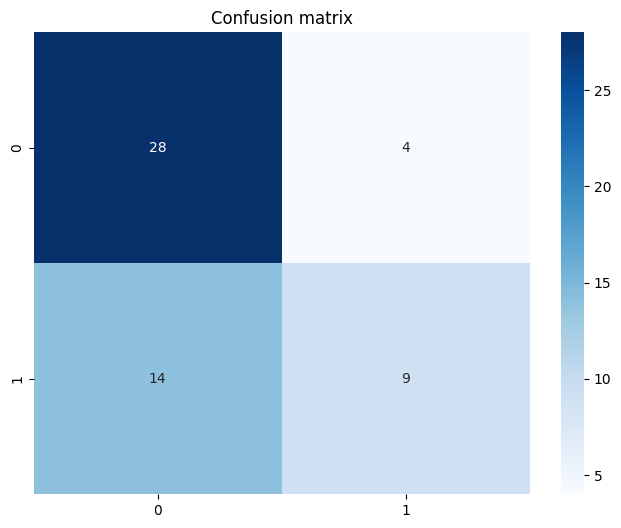

In [ ]:
forest = RandomForestClassifier(n_estimators=100)
custom_clfCV = CustomClassifierCV(forest)
custom_clfCV.fit(X, y)

# **XGB**

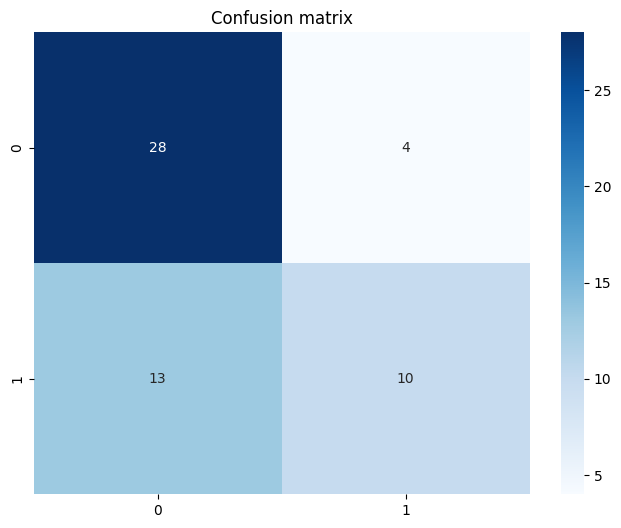

In [ ]:
model_XGB = xgb.XGBClassifier()
custom_clfCV = CustomClassifierCV(model_XGB)
custom_clfCV.fit(X, y)

In [ ]:
from sklearn.svm import LinearSVC

# **SVM**

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

              precision    recall  f1-score   support

           0       0.69      0.67      0.68        33
           1       0.52      0.55      0.53        22

    accuracy                           0.62        55
   macro avg       0.60      0.61      0.61        55
weighted avg       0.62      0.62      0.62        55

Confusion Matrix:
[[22 10]
 [11 12]]


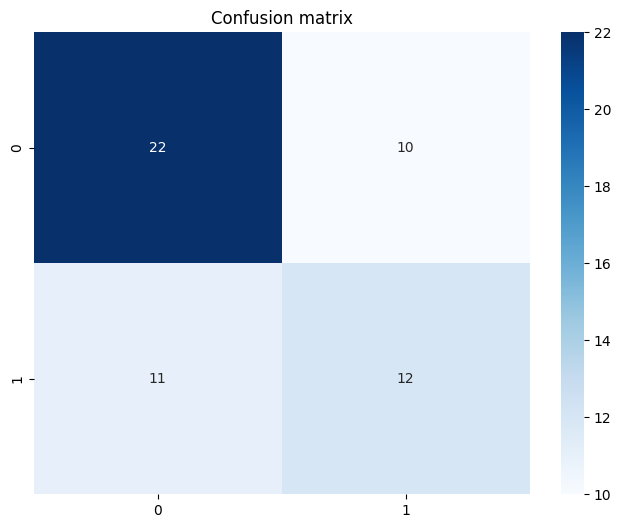

In [ ]:
model_SVM = LinearSVC(C=10)
custom_clfCV = CustomClassifierCV(model_SVM )
custom_clfCV.fit(X, y)

In [ ]:
from sklearn.svm import SVC

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        50
           1       0.22      1.00      0.36         5

    accuracy                           0.67        55
   macro avg       0.61      0.82      0.57        55
weighted avg       0.93      0.67      0.74        55

Confusion Matrix:
[[32  0]
 [18  5]]


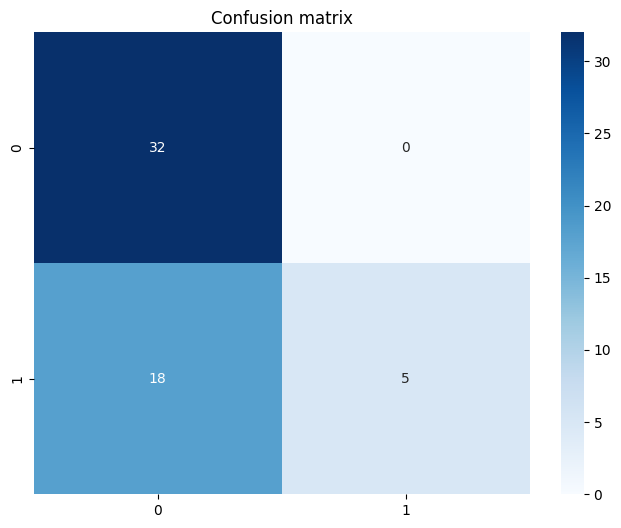

In [ ]:
model_SVM = SVC(kernel='rbf', C=10)
custom_clfCV = CustomClassifierCV(model_SVM )
custom_clfCV.fit(X, y)

# **NAIVE BAYES**

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB

              precision    recall  f1-score   support

           0       0.75      0.51      0.61        47
           1       0.00      0.00      0.00         8

    accuracy                           0.44        55
   macro avg       0.38      0.26      0.30        55
weighted avg       0.64      0.44      0.52        55

Confusion Matrix:
[[24  8]
 [23  0]]


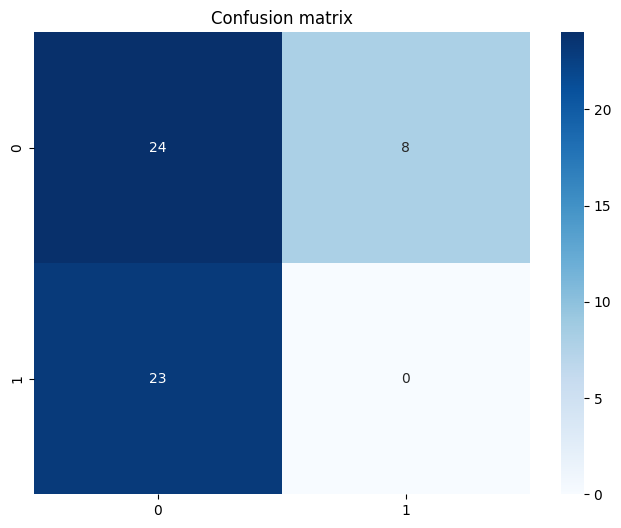

In [ ]:
model_MNB = MultinomialNB()
custom_clfCV = CustomClassifierCV(model_MNB )
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.19      0.75      0.30         8
           1       0.91      0.45      0.60        47

    accuracy                           0.49        55
   macro avg       0.55      0.60      0.45        55
weighted avg       0.81      0.49      0.56        55

Confusion Matrix:
[[ 6 26]
 [ 2 21]]


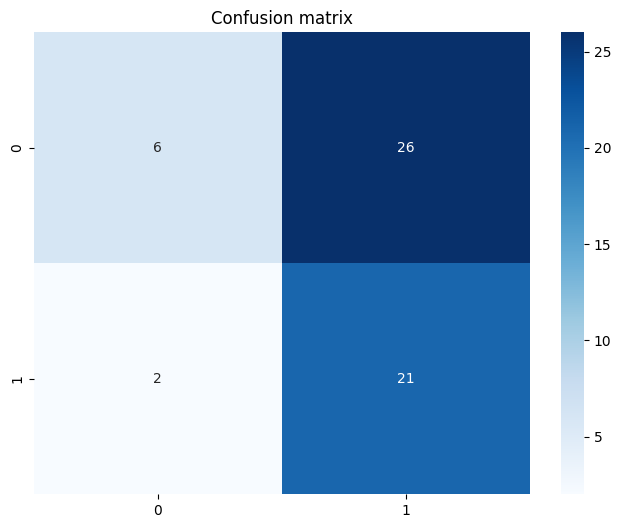

In [ ]:
model_GNB = GaussianNB()
custom_clfCV = CustomClassifierCV(model_GNB )
custom_clfCV.fit(X, y)

              precision    recall  f1-score   support

           0       0.97      0.57      0.72        54
           1       0.00      0.00      0.00         1

    accuracy                           0.56        55
   macro avg       0.48      0.29      0.36        55
weighted avg       0.95      0.56      0.71        55

Confusion Matrix:
[[31  1]
 [23  0]]


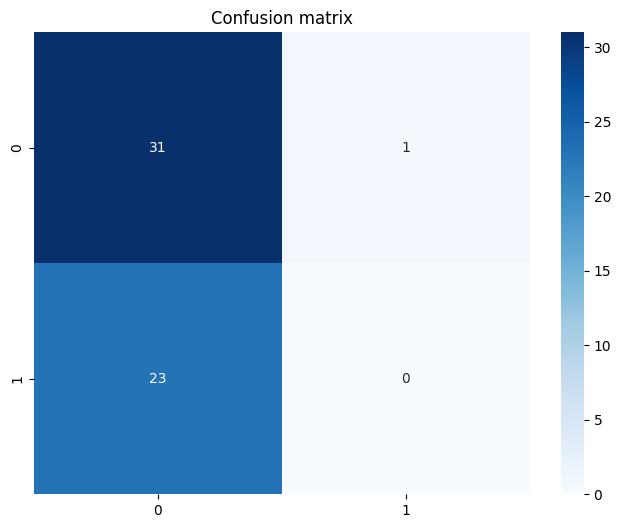

In [ ]:
model_BNB = BernoulliNB()
custom_clfCV = CustomClassifierCV(model_BNB )
custom_clfCV.fit(X, y)

### **LOGISTIC REGRESSION**

In [ ]:
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.97      0.62      0.76        50
           1       0.17      0.80      0.29         5

    accuracy                           0.64        55
   macro avg       0.57      0.71      0.52        55
weighted avg       0.90      0.64      0.71        55

Confusion Matrix:
[[31  1]
 [19  4]]


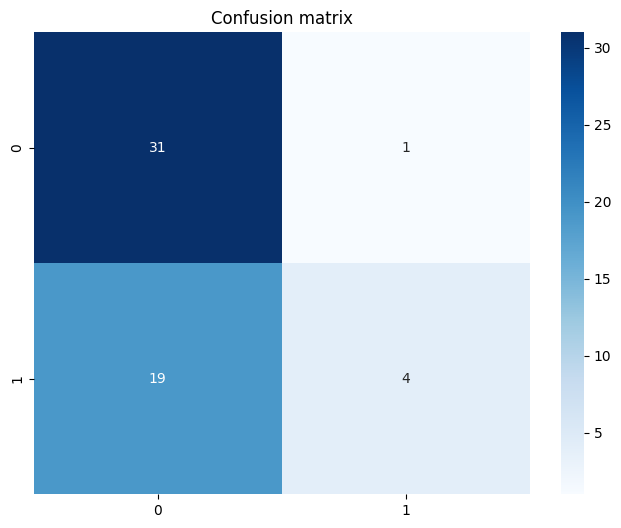

In [ ]:
model_BNB = LogisticRegression(solver = 'lbfgs')
custom_clfCV = CustomClassifierCV(model_BNB )
custom_clfCV.fit(X, y)

### **KNN**

              precision    recall  f1-score   support

           0       0.94      0.67      0.78        45
           1       0.35      0.80      0.48        10

    accuracy                           0.69        55
   macro avg       0.64      0.73      0.63        55
weighted avg       0.83      0.69      0.73        55

Confusion Matrix:
[[30  2]
 [15  8]]


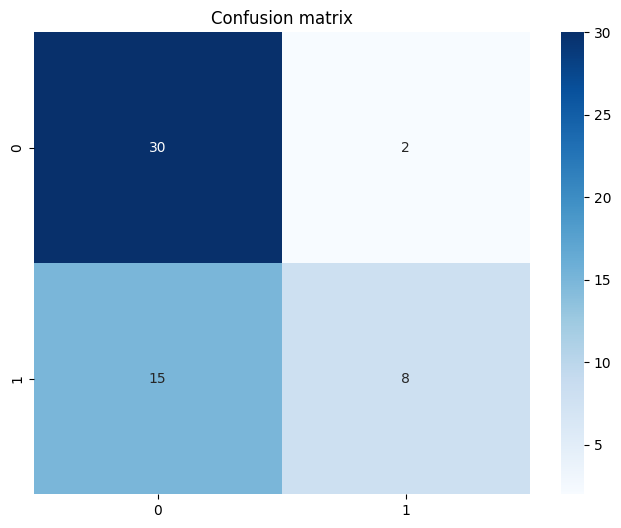

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
custom_clfCV = CustomClassifierCV(knn )
custom_clfCV.fit(X, y)

In [ ]:
full_df['state'].value_counts()

0    739
1    405
Name: state, dtype: int64

### **CNN**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Split the full_dfset into input features and output labels
X = full_df.iloc[:, :-1].values
X = full_df.drop('source', axis=1).values

y = full_df.iloc[:, -1].values

# Split the full_df into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input features for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the CNN model
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold to convert probabilities into binary labels
threshold = 0.5
y_pred = binarize(y_pred_prob, threshold=threshold).flatten()

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/10
25/25 [==============================] - 2s 13ms/step - loss: 0.5890 - accuracy: 0.7788 - val_loss: 0.4459 - val_accuracy: 0.9041
Epoch 2/10
25/25 [==============================] - 0s 6ms/step - loss: 0.3800 - accuracy: 0.9212 - val_loss: 0.2890 - val_accuracy: 0.9651
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 0.2167 - accuracy: 0.9712 - val_loss: 0.1712 - val_accuracy: 0.9651
Epoch 4/10
25/25 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.9837 - val_loss: 0.1124 - val_accuracy: 0.9709
Epoch 5/10
25/25 [==============================] - 0s 6ms/step - loss: 0.0734 - accuracy: 0.9900 - val_loss: 0.0766 - val_accuracy: 0.9709
Epoch 6/10
25/25 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.9900 - val_loss: 0.0568 - val_accuracy: 0.9738
Epoch 7/10
25/25 [==============================] - 0s 6ms/step - loss: 0.0348 - accuracy: 0.9950 - val_loss: 0.0391 - val_accuracy: 0.9913
Epoch 8/10
25/25 [=

### **RNN**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
data = full_df

# Split the dataset into input features and output labels
X = data.iloc[:, :-1].values
X = full_df.drop('source', axis=1).values

y = data.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape the input features for RNN (3D input shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the RNN model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold to convert probabilities into binary labels
threshold = 0.5
y_pred = np.where(y_pred_prob > threshold, 1, 0)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/10
25/25 [==============================] - 3s 33ms/step - loss: 0.6660 - accuracy: 0.6225 - val_loss: 0.6069 - val_accuracy: 0.7558
Epoch 2/10
25/25 [==============================] - 0s 9ms/step - loss: 0.5828 - accuracy: 0.7150 - val_loss: 0.5205 - val_accuracy: 0.7180
Epoch 3/10
25/25 [==============================] - 0s 13ms/step - loss: 0.5206 - accuracy: 0.6837 - val_loss: 0.4555 - val_accuracy: 0.7965
Epoch 4/10
25/25 [==============================] - 0s 13ms/step - loss: 0.4417 - accuracy: 0.7937 - val_loss: 0.3598 - val_accuracy: 0.8285
Epoch 5/10
25/25 [==============================] - 0s 12ms/step - loss: 0.3227 - accuracy: 0.9237 - val_loss: 0.2447 - val_accuracy: 0.9709
Epoch 6/10
25/25 [==============================] - 0s 11ms/step - loss: 0.2011 - accuracy: 0.9762 - val_loss: 0.1453 - val_accuracy: 0.9971
Epoch 7/10
25/25 [==============================] - 0s 12ms/step - loss: 0.1153 - accuracy: 0.9975 - val_loss: 0.0789 - val_accuracy: 1.0000
Epoch 8/10
25/

### **ANN**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense

# Load the dataset
data = full_df

# Split the dataset into input features and output labels
X = data.iloc[:, :-1].values
X = data.drop('source', axis=1).values

y = data.iloc[:, -1].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predict probabilities
y_pred_prob = model.predict(X_test)

# Apply threshold to convert probabilities into binary labels
threshold = 0.5
y_pred = np.where(y_pred_prob > threshold, 1, 0)

# Generate classification report
report = classification_report(y_test, y_pred)
print(report)


Epoch 1/10
25/25 [==============================] - 1s 10ms/step - loss: 0.5676 - accuracy: 0.8800 - val_loss: 0.4217 - val_accuracy: 0.9855
Epoch 2/10
25/25 [==============================] - 0s 4ms/step - loss: 0.3291 - accuracy: 0.9787 - val_loss: 0.2231 - val_accuracy: 0.9884
Epoch 3/10
25/25 [==============================] - 0s 4ms/step - loss: 0.1571 - accuracy: 0.9925 - val_loss: 0.1004 - val_accuracy: 0.9884
Epoch 4/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0672 - accuracy: 0.9987 - val_loss: 0.0441 - val_accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0304 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 0s 4ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 8/10
25/25 [=